# LArTPC particle classification

This colab notebook provides an example of classifying particles in a liquid argon time projection chamber (LArTPC) using a Convolutional Neural Network (CNN).

LArTPCs are a type of detector being used by current and future neutrino experiments. For these experiments, the detectors cannot observe the neutrino directly -- due to being neutrino -- but must infer its properties from the particles the neutrino makes when it interacts with nuclei in the detector.

LArTPCs, as will be explained later, can be thought of as a camera taking pictures of charged particle trajectories. So one important tasks is to identify what particle produced a given collection of pixels.

For this hackathon project, we've provided a data set of simulated images containing the trajectories produced by five particle types: electrons, gammas, muons, protons, and charged pions. The data is in the form of some binary files containing each storing an image in the form of a numpy array.

Also, we have provide some pytorch classes that can help you play with the data along with some example code on implementing a CNN (ResNet-18) and training loop. There is also a checkpoint file for a simply trained model to use as a benchmark.




## Example of the data

Below is a figure containing example images along with true and predicted labels. (The predicted labels and score come from the provided benchmark model.)

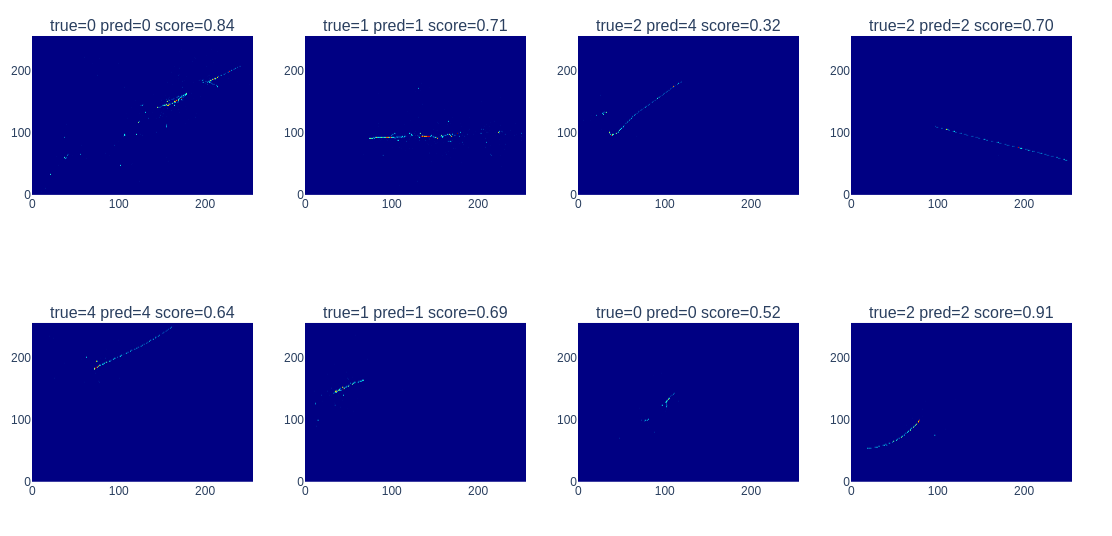

# Possible ideas for the hackathon

We challenge you to try out different ways to classify the images and compare to the benchmark model. 

If you follow the notebook and repeat the training of the network you will likely find that the model overfits relatively quickly. I get an accuracy of roughly 80% after roughly 10 epochs.

There are some things we can do to improve upon this or to simply explore:

*   Evaluate the accuracy and confusion matrix of the baseline model running on the validation set. We include a cell below that runs on a subset and visualizes the data. You can use that as example code.
*   Improve upon a baseline by implementating data augmentation strategies. The baseline model does not use any. Basic options are flips, crops, stretches and variations in the value. Something maybe more fun to try is [MixUp](https://arxiv.org/abs/1710.09412v2).
*   One could try using the equivariant CNNs (e.g. the steerable CNNs) we learned about this week.
*   Maybe try training a different model type. e.g. [vision transformer](https://arxiv.org/abs/2010.11929) [implementation here](https://github.com/lucidrains/vit-pytorch).
*   Use the default model, but start with pre-trained ImageNet weights. There is a flag in the `lartpcDataset` class that will load these weights, but you'll need to make a few modifications to get things to work (e.g. must turn single channel input into three-channel (false RGB) input.
*   Take advantage of the sparsity in the images and employ sparse convolutions, e.g. library [sparseconvnet](https://github.com/facebookresearch/SparseConvNet), [spconv](https://github.com/traveller59/spconv), [MinkowskiEngine](https://github.com/NVIDIA/MinkowskiEngine.git). Warning -- these libraries can be tricky to install.


Beyond classification:

* There is meta data associated with each image: (px, py, pz) and the total momentum. We can attempt to regress the values.


## How are the images made

The images are simulations of what you might see in a LArTPC.

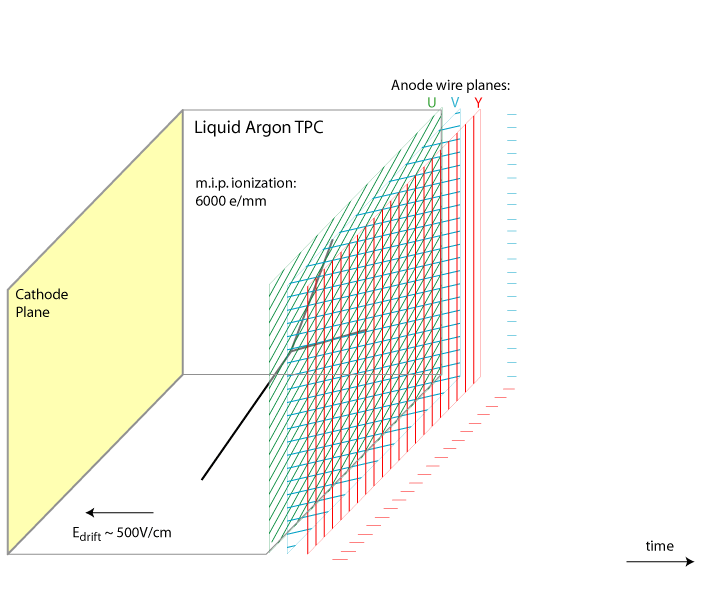

## The detector

The above gif is a cartoon of how the detector works and how the images are formed.  

You can think of the detector as a big tank of cryogenic liquid argon with what is essentially a big parallel-plate capacitor inside, with one side (the cathode) held a large negative potential (e.g. past experiments use -75 and -125 kilovolts). This creates a mostly uniform field between the anode and cathode.

When charged a charged particle crosses the detector it ionizes the argon atoms along its path. This leaves behind a narrow cloud of electrons (shown in the black lines.)

Because of the electric field, the ionization cloud will drift to the anode. At the anode, an array of charge sensitive electroncs are installed. They will produce a measurable voltage pulse when the ionization cloud passes by. In the gif above, the electronics are in the form of sense wires. 

By recording the voltage versus time of all the wires, we can form an image by  taking all the signals and concatenating a wire channel dimension. These are the red and blue "images" being formed. In this way we get a projected view of the 3D trajectory of the charged particles. 

# Setting up a runtime

But first before starting, you should decide upon the runtime you'll use for this notebook. You can choose which runtime in the upper right-hand corner from either the "Connect" button or a drop down menu marked by an upside-down triangle.

Your choices are:

* Connect to a hosted runtime
* Connect to a custom GCE VM
* Connect to a local runtime

The main thing to consider is if you will be attempting a training run using this notebook.  Using a CPU is likely impractical. So you'll either need to choose the "custom GCE VM" to use your Google Cloud credits from the course or if you have a laptop with a GPU you can choose the "local runtime" option.

Note that the repository we use has a python script that can be used to run some training on your laptop or on some machine with GPUs you might have access to. See the section about the repository below. If doing this, you can use this notebook just for viewing some example images. In that case choosing the "hosted runtime" option might the most sense.


# Setting up the notebook

Assuming that a runtime has been chosen, we can begin to setup the notebook.

We'll need to 

*   Install python packages
*   Download the associated github repo for this tutorial
*   Upload the data into the notebook

We've outlined a few ways to get the data into the notebook.

## Packages

In [ ]:
# Install the data we need
%%capture
!pip install chart_studio plotly kaleido wandb pytorch_lightning gdown

In [ ]:
# import the modules
import numpy as np
import torch
import torchvision
import kaleido
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%load_ext autoreload
%autoreload 2

## The repository

Here we clone the repository. It provides

* a pytorch DatasetFolder class that will we'll use to load the data
* a pytorch lightning module for training
* an implementation of a ResNet-18 model used as a default model

In [ ]:
# Clone the repo. Provides:
#  an interface we can use to load the data. Also defines a default model
! git clone https://github.com/NuTufts/lartpc_ml_tutorial /content/lartpc_ml_tutorial

The training module and data loader is written to run inside the repository directory, so we go into the directory here. We also dump the contents of the directory. Some notes on the modules:

* lartpcdataset.py: provides interface to data
* engine_lightning.py: provides pytorch-lightning module
* resnet.py: implements residual network
* train_lightning.py: script for running training outside of the colab environment.

If you want to use `train_lightning.py` you'll need to install the same set of packages as in the above cell.

In [ ]:
%cd /content/lartpc_ml_tutorial/
!pwd
!ls -lh

## Getting the data

There data is provided in two tar files, one for the training dataset and another for a validation set.  

The tar files can be found at the following google drive folder (along with this notebook):

[IAIFI Summer School 22 LArTPC Classication Materials](https://drive.google.com/drive/folders/1uCXt81lJNRJncGbkOFZjSMMaAXqjY79w?usp=sharing)

There are three different ways I've played around with in getting the data into the notebook. Different ways work or don't work depending on the runtime (and I'm not an expert enough at colabs notebooks or setting up google cloud VMs to understand why).

*   Manually uploading the data into the notebook via the upload button on the left hand side. (Click the file folder icon on the left to bring up the `Files` panel. Then you can click up the upload button (File icon with up arrow).
*   Download the files using the `gdown` package installed above.
*   If you have a google drive account, make a short-cut to the google drive folder with the data in your drive space and then mount it to this notebook instance.

The first one should always be possible, though potentially slow and the definitely the least elegant. (If you have recomendations, I'd be happy to hear it.)






### Upload the data

After uploading, untar the files. Make sure that the files are made in the `/content/lartpc_ml_tutorial` folder.

If you got the data into the notebook another way, skip this subsection.

In [ ]:
# untar the data
!tar -xzf /content/lartpc_ml_tutorial/lartpc_training_data.tar.gz
!tar -zxf /content/lartpc_ml_tutorial/lartpc_valid_data.tar.gz

### Use gdown to download it from the google drive folder

If you get the data in another way, skip these lines.

In [ ]:
# Get the data: validation sample (24 MB)
!gdown --fuzzy https://drive.google.com/file/d/1KxNXBeNv_SH7g3iM9yuR50JS09ZxoEc3/view?usp=sharing

In [ ]:
# Get the data: training sample (241 MB)
# gdown doesn't work -- might be too large of a file?
# Go to this URL and download: https://drive.google.com/file/d/14Zft7allKsHtps8KI3d0wlT3GH_P8dcu/view?usp=sharing
# then upload manually using filesystem interface on the left-hand menu bar
!gdown --fuzzy https://drive.google.com/file/d/14Zft7allKsHtps8KI3d0wlT3GH_P8dcu/view?usp=sharing

In [ ]:
# untar the data
!tar -xzf /content/lartpc_ml_tutorial/lartpc_training_data.tar.gz
!tar -zxf /content/lartpc_ml_tutorial/lartpc_valid_data.tar.gz

### Mounted your google drive

If you go this route, get the drive to show up by making a shortcut to the folder. Right-click on the name of the folder at the top and choose "Add shortcut to Drive".

If you get the data in another way, skip these lines.

In [ ]:
# use these lines if using mounted google drive folder 
# Does not work: could not 
!tar -xzf /content/drive/MyDrive/IAIFI_SummerSchool22_lartpc_classification/lartpc_training_data.tar.gz
!tar -xzf /content/drive/MyDrive/IAIFI_SummerSchool22_lartpc_classification/lartpc_valid_data.tar.gz


### Check the working directory

Run this to look around, confirming the data is unpacked in the right spot.
Note: the code from the repo works in `/content/lartpc_ml_tutorial`, so we move there.

You should see something like this.

The thing to note for is the `data` and `valid` directory which contain the training and validation image set, respectively.

```
///// current working directory ////
/content/lartpc_ml_tutorial
 data		       lartpc_valid_data.tar.gz		 valid
 dev		       __pycache__			'view?usp=sharing'
 engine_lightning.py   resnet.py			 visualize_data.ipynb
 __init__.py	       train_lightning.py		 wandb
 lartpcdataset.py      tutorial-colab-resnet-lightning
 ```

### Structure of the data in the folders. 

If you also want to spy into the data folder structure, use the line below. But you'll find that in the `data` and `valid` directories you'll first find a view directory.  LArTPCs produce a set of images for each event, with each image providing a different tomographic or projective view of the same 3D charge trajectories. For each particle simulated, we have three views made by simple projections in the xy, yz, and zx planes, labels with "x", "y", and "z" in the folder names. We'll only use the xz or "z" plane for what follows below -- but one project for improving the training of the model is to use these additional view images as additional data.

In [ ]:
# if you also want to spy into the data folder structure, use this line:
!find data -type d

# Visualizating the data

Presuming you've gottent the data, here are some cells for looking at the images.

In [ ]:
# Dictionary between class ID and particle name
LABEL_NAME = {0:"electron",
             1: "gamma",
             2:"muon",
             3:"proton",
             4:"pion"}

## Set up a test instance for the data set



In [ ]:
# Make interface to train and valid data sets
# We only use the z-view in this setup.
from lartpcdataset import lartpcDataset

# note for this viewing, we use the `load_meta_data` flag to load additional information for each instance
test_dataset = lartpcDataset(root="./valid/z-view",load_meta_data=True,) 

## Plotting the data


In [ ]:
# Plot some examples for each class

# make a loader for giving us some images that comes with meta data (the particle momentum)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True)

NUM_IMGS_PER_CLASS = 9
NUM_IMGS_PER_ROW = 3

image_bank = {}
mom_bank = {}
for labelid in LABEL_NAME:
    image_bank[labelid] = []
    mom_bank[labelid] = []

xaxis = np.linspace( 0, 256, endpoint=False, num=256 )
yaxis = np.linspace( 0, 256, endpoint=False, num=256 )
    
done = False
while not done:
    batch = next(iter(test_loader))
    data = batch[0]
    label = batch[1].item()
    img = data[0]
    meta = data[1]
    if len(image_bank[label])<NUM_IMGS_PER_CLASS:
        image_bank[label].append( img )
        mom_bank[label].append( meta[0][-1].item() )
    done = True
    for labelid in LABEL_NAME:
        if len(image_bank[labelid])<NUM_IMGS_PER_CLASS:
            done = False
print("Image bank made")

#Plot them
from plotly.subplots import make_subplots
class_figs = {}
NROWS = int(NUM_IMGS_PER_CLASS/NUM_IMGS_PER_ROW)
print("NROWS: ",NROWS)
for labelid in LABEL_NAME:
    #print("N IMAGES LABEL=",labelid,": ",len(image_bank[labelid]))
    
    # subplot titles
    subtitles = [ "p=%.2f MeV"%(x) for x in mom_bank[labelid] ]
    
    fig = make_subplots(rows=NROWS, cols=NUM_IMGS_PER_ROW, subplot_titles=subtitles )
    for n,img in enumerate(image_bank[labelid]):
        imgplot = {                                                                                                                                                                  
        "type":"heatmap",
        "z":img.squeeze(),
        "x":xaxis,
        "y":yaxis,
        "zmin":0.0,
        "zmax":10.0,
        "colorscale":"Jet",
        "showscale":False
        }
        #print(int(n/NUM_IMGS_PER_ROW)+1, n%NUM_IMGS_PER_ROW+1)
        fig.add_trace(imgplot, int(n/NUM_IMGS_PER_ROW)+1, n%NUM_IMGS_PER_ROW+1)
    fig.update_layout(height=900, width=900, title_text="%s examples"%(LABEL_NAME[labelid]))
    fig.show()

# Training

In [ ]:
# optional: log into wandb, only do once when starting up notebook again
# import wandb

# I think what you should do is log into wandb from the laptop or computer running this notebook.
# then run the following in this cell.
# wandb.login()

# However, you might have issues -- the notebook will hang and you might have to reset the runtime (CRTL+M or choose reset in the "Runtime" menu above.). 
# If so you can go to https://wandb.ai/authorize. Copy the key and put it here. But careful not to save and share the notebook as it might save your API key.
#wandb.login(key="XXXX")

In [ ]:
# Import modules we need to do some training
from engine_lightning import LitEngineResNet # from the lartpc_ml_tutorial repo
import pytorch_lightning as pl # a nice utility for training models with pytorch
from pytorch_lightning.loggers import WandbLogger # interface to wandb

In [ ]:
# Define data loaders for the training
BATCHSIZE=64

from lartpcdataset import lartpcDataset
train_dataset = lartpcDataset(root="./data/z-view")
valid_dataset = lartpcDataset(root="./valid/z-view")

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCHSIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCHSIZE,
    shuffle=False)

In [ ]:
# make the lightning module (contains model and defines training steps)
DEVICE = torch.device("cuda")
model = LitEngineResNet(lr=1.0e-2).to(DEVICE)
print("lr=",model.lr)

## The default model

In [ ]:
#Dump the model
model.print_model()

## Training loop

In [ ]:
# Runs one forward pass and calcs loss
print("//////// TESTING BLOCK //////////")
imgs, labels = next( iter(train_loader) )
imgs = imgs.to(DEVICE)
labels = labels.to(DEVICE)
print("imgs: ",imgs.shape)
print("labels: ",labels.shape," :: ",labels)
out = model.forward(imgs)
print(out.shape)

loss = model.calc_loss( out, labels )
print(loss)

In [ ]:
# OPTIONAL: Display training metrics using Weights and Biases
# Warning: if you're using a Google Cloud Computer Engine, note that
#          data needs egress from the compute node to the W&B servers I believe counts against your credits
#          Note that while I was testing this notebook on a GCE instance, I spent a total of $6 or so doing O(10) runs.
# wandb_logger = WandbLogger(project='tutorial-colab-resnet-lightning') # uncomment this if using W&B

# defining a callback to run every epoch and save a model checkpoint
# also making a directory for the files to go
#%mkdir -p checkpoints
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/lartpc_ml_tutorial/checkpoints/',
                                                   filename='{epoch}-{step}-{val_loss:.2f}',
                                                   save_top_k=10,
                                                   monitor='val_loss',
                                                   save_on_train_epoch_end=True)

# train on the CPU (probably not going to finish in a reasonable amount of time)
# trainer = pl.Trainer(accelerator="cpu",
#                      precision=16,
#                      limit_train_batches=0.5,
#                      #logger=wandb_logger, # uncomment if using W&B
#                      max_epochs=5,
#                      callbacks=[checkpoint_callback])

trainer = pl.Trainer(default_root_dir="/content/lartpc_ml_tutorial/",
                     accelerator="gpu",
                     gpus=1,
                     precision=16,
                     limit_train_batches=0.5,
                     #logger=wandb_logger, # uncomment if using W&B
                     max_epochs=5,
                     callbacks=[checkpoint_callback])
           
trainer.fit(model, train_loader, val_loader)

In [ ]:
# run if you used wandb after the training finishes.
wandb.finish()

## Checkpoints

In [ ]:
# The checkpoint should be here somewhere
# looking for files ending in 'ckpt' and then using `ls` to get the time-stamp to see the most recent ones.
!find checkpoints | grep ckpt |  sort | xargs -I {} ls -lh {}
#!find tutorial-colab-resnet-lightning | grep ckpt | xargs -I {} ls -lh {}

In [ ]:
# let's copy the checkpoint for safe-keeping in case we unintentional delete the compute instance
# only if you were able to mount your google drive to the runtime
# !cp checkpoints/[mycheckpt].pth /content/drive/MyDrive/

# Inference

## There is a checkpoint you can use to benchmark against or to test

In [ ]:
# copy a pretrained model from the google drive

!gdown --fuzzy https://drive.google.com/file/d/1HtjUlsU0ekG6SfTK9MHzYaLBgSzZHq4E/view?usp=sharing

## Load your checkpoint and the model

In [ ]:
# load checkpoint
#CHECKPOINT_FILE = "tutorial-colab-resnet-lightning/3b2iyonk/checkpoints/epoch=9-step=3910.ckpt"
CHECKPOINT_FILE = "/content/lartpc_ml_tutorial/epoch=9-step=3910.ckpt" # The google drive checkpoint
map_loc = {"cuda":"cpu","cuda:0":"cpu"}
checkpoint = torch.load(CHECKPOINT_FILE, map_location=map_loc)
print(checkpoint.keys())

In [ ]:
from engine_lightning import LitEngineResNet # from the lartpc_ml_tutorial repo
inference_model = LitEngineResNet().to("cpu")
inference_model.load_state_dict( checkpoint["state_dict"] )
inference_model.model.eval()


## Running inference on a small subset and visualize output

In [ ]:
# make a loader for giving us some images that comes with meta data (the particle momentum)
# Test and visualize

DEVICE = torch.device("cuda")
#DEVICE = torch.device("cpu")
inference_model.to(DEVICE)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=True)

NUM_IMAGES_TO_RUN = 16
NUM_IMGS_PER_ROW = 4

output = []

xaxis = np.linspace( 0, 256, endpoint=False, num=256 )
yaxis = np.linspace( 0, 256, endpoint=False, num=256 )
    
num_processed = 0
while num_processed<NUM_IMAGES_TO_RUN:
    batch = next(iter(test_loader))
    data = batch[0]
    label = batch[1].to(DEVICE)
    #print(label)
    img = data[0].to(DEVICE)
    bs = img.shape[0]
    idx = torch.arange(bs,dtype=torch.long)
    #print(idx)
    meta = data[1]
    with torch.no_grad():
      pred = inference_model.forward( img )
      pred = torch.nn.Softmax( dim=1 )(pred)
      print("pred \\\ ",pred.shape)
      #print(pred)
      xlabel = label.view(bs,1)
      #print("xlabel: ",xlabel)
      selscore = pred[ idx[:], label[:] ]
      selclass = torch.argmax( pred, dim=1 )
      #print(selscore)
      #print(selclass)
      print("selclass.shape: ",selclass.shape)
      acc = selclass.eq(label).sum()/float(bs)
      print(acc)
      for i in range(bs):
        output.append( (img[i].cpu().numpy(), selscore[i].item(), selclass[i].item(), label[i].item() ) )
    num_processed += img.shape[0]
print("Ran images")

#Plot them
from plotly.subplots import make_subplots
subtitles = []
for (img,score,selclass,trueclass) in output:
    subtitles.append( "true=%d pred=%d score=%.2f"%(trueclass,selclass,score) )
    #print("N IMAGES LABEL=",labelid,": ",len(image_bank[labelid]))

NROWS = int(len(output)/NUM_IMGS_PER_ROW)
if len(output)%NUM_IMGS_PER_ROW!=0:
  NROWS+=1
fig = make_subplots(rows=NROWS, cols=NUM_IMGS_PER_ROW, subplot_titles=subtitles )
for n,(img,score,selclass,trueclass) in enumerate(output):
    imgplot = {                                                                                                                                                                  
      "type":"heatmap",
      "z":img.squeeze(),
      "x":xaxis,
      "y":yaxis,
      "zmin":0.0,
      "zmax":10.0,
      "colorscale":"Jet",
      "showscale":False
    }
    #print(int(n/NUM_IMGS_PER_ROW)+1, n%NUM_IMGS_PER_ROW+1)
    fig.add_trace(imgplot, int(n/NUM_IMGS_PER_ROW)+1, n%NUM_IMGS_PER_ROW+1)
fig.update_layout(height=300*NROWS, width=300*NUM_IMGS_PER_ROW, title_text="predictions")
fig.show()
fig.write_image("fig1.png")

# Misc

Just some cells I use to check and develop this notebook.

In [ ]:
# This block can be used to check that your compute instance has a GPU.
!nvidia-smi

In [ ]:
!git pull

In [ ]:
%rm -r /content/lartpc_ml_tutorial/checkpoints

In [ ]:
!ls -lh /content/lartpc_ml_tutorial/checkpoints

In [ ]:
!ls -lh /content/lartpc_ml_tutorial/lightning_logs/

In [ ]:
%rm /content/lartpc_ml_tutorial/checkpoints/*

In [ ]:
%rm -r /content/lartpc_ml_tutorial/lightning_logs/*